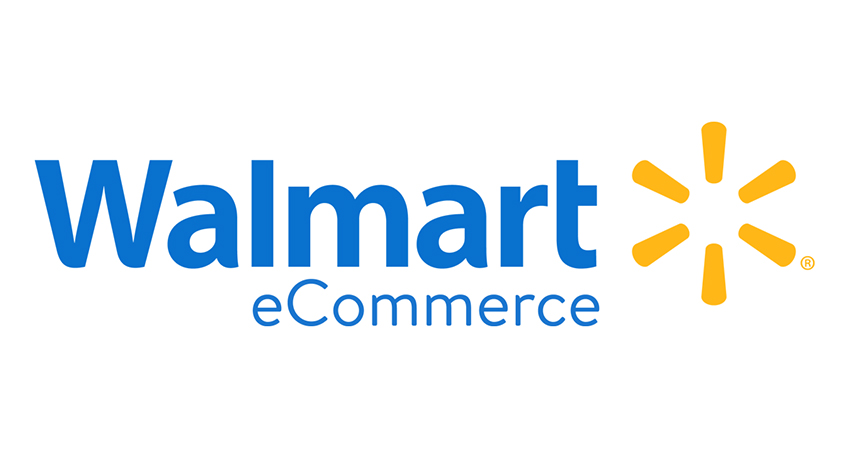

Walmart is the biggest retail store in the United States.

Just like others, they have been expanding their e-commerce part of the business.

By the end of 2022, e-commerce represented a roaring $80 billion in sales, which is 13% of total sales of Walmart.

One of the main factors that affects their sales is public holidays, like the Super Bowl, Labour Day, Thanksgiving, and Christmas.

# `grocery_sales`
- `"index"` - unique ID of the row
- `"Store_ID"` - the store number
- `"Date"` - the week of sales
- `"Weekly_Sales"` - sales for the given store

Also, you have the `extra_data.parquet` file that contains complementary data:

# `extra_data.parquet`
- `"IsHoliday"` - Whether the week contains a public holiday - 1 if yes, 0 if no.
- `"Temperature"` - Temperature on the day of sale
- `"Fuel_Price"` - Cost of fuel in the region
- `"CPI"` – Prevailing consumer price index
- `"Unemployment"` - The prevailing unemployment rate
- `"MarkDown1"`, `"MarkDown2"`, `"MarkDown3"`, `"MarkDown4"` - number of promotional markdowns
- `"Dept"` - Department Number in each store
- `"Size"` - size of the store
- `"Type"` - type of the store (depends on `Size` column)


In [3]:
import pandas as pd
import datetime

# Read the dataset into memory, and take a look at the first few rows
grocery_sales_df = pd.read_csv('https://raw.githubusercontent.com/EcklBar/Projects/refs/heads/main/Building%20a%20Retail%20Data%20Pipeline/grocery_sales.csv', index_col=0)
grocery_sales_df.head()

,index,Store_ID,Date,Dept,Weekly_Sales
0,0,1,2010-02-05,1,24924.50
1,1,1,2010-02-05,26,11737.12
2,2,1,2010-02-05,17,13223.76
3,3,1,2010-02-05,45,37.44
4,4,1,2010-02-05,28,1085.29


In [2]:
# Also, read the extra data into memory
extra_data_df = pd.read_parquet('https://github.com/EcklBar/Projects/raw/refs/heads/main/Building%20a%20Retail%20Data%20Pipeline/extra_data.parquet')
extra_data_df.head()

,index,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3.0,151315.0
1,1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3.0,151315.0
2,2,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3.0,151315.0
3,3,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,NaN,3.0,151315.0
4,4,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,NaN,3.0,151315.0


In [ ]:
# Perform some basic EDA (column names, number of records, types, etc)
print(extra_data_df.columns)
print(extra_data_df.shape)
print(extra_data_df.dtypes)

In [ ]:
# Extract function
def extract(csv_path, parquet_path):
    """
    Description:
        This function extracts data from a CSV and a Parquet file and merges them.
        It also prints some basic information about the CSV data.

    Args:
        csv_path (str): Path to the CSV file.
        parquet_path (str): Path to the Parquet file.

    Returns:
        pd.DataFrame: Merged DataFrame from the two files.
    """
    # Read the CSV file
    data1 = pd.read_csv(csv_path, index_col=0)

    # Read the Parquet file
    date2 = pd.read_parquet(parquet_path)

    # Print details about the CSV data
    print(f"Here is a little bit of information about the data stored in {csv_path}:")
    print(f"\nThere are {data1.shape[0]} rows and {data1.shape[1]} columns in this DataFrame.")
    print("\nThe columns in this DataFrame take the following types: ")
    print(data1.dtypes)

    # Merged between the dataframes
    merged_df = data1.merge(date2, on='index')

    print(f"\nDataFrames merged successfully!\n")
    return merged_df

# Example usage
csv_url = 'https://raw.githubusercontent.com/EcklBar/Projects/refs/heads/main/grocery_sales.csv'
parquet_url = 'https://github.com/EcklBar/Projects/raw/refs/heads/main/extra_data.parquet'

merged_df = extract(csv_url, parquet_url)

# Show
merged_df.head()

In [ ]:
# Get DataFrame information
merged_df.info()

### Transforming Data

In [ ]:
def transform(raw_data):
  # Convert Date to date type
  raw_data['Date'] = pd.to_datetime(raw_data['Date']).dt.date

  # Save today's date
  today = dt.date.today()

  # Future dates
  raw_data.loc[raw_data['Date'] > today, 'Date'] = today

  # Drop duplictaes
  raw_data.drop_duplicates(inplace=True)

  # Fill NaNs using mean since we are dealing with numeric columns and date with the previous date column
  raw_data.fillna(
      {
          'CPI': raw_data['CPI'].mean(),
          'Weekly_Sales': raw_data['Weekly_Sales'].mean(),
          'Unemployment': raw_data['Unemployment'].mean(),
          'Date': raw_data['Date'].fillna(method='ffill') # Use forward fill for date columns

      }, inplace = True
    )

  # Define the type of the "Date" column and its format
  raw_data['Date'] = pd.to_datetime(raw_data['Date'], format = "%Y-%m-%d")

  # Extract the month value from the "Date" column to calculate monthly sales later on
  raw_data['Month'] = raw_data['Date'].dt.month

  # Filter the entire DataFrame using the "Weekly_Sales" column. Use .loc to access a group of rows
  raw_data = raw_data.loc[raw_data['Weekly_Sales'] > 10000, :]

  # Drop unnecessary columns. Set axis = 1 to specify that the columns should be removed
  raw_data = raw_data.drop(["index", "Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Type", "Size", "Date"], axis = 1)

  return raw_data

In [ ]:
# Call the transform() function and pass the merged DataFrame
clean_data = transform(merged_df)

In [ ]:
clean_data.head()

In [ ]:
# Create the avg_weekly_sales_per_month function that takes in the cleaned data from the last step
def avg_weekly_sales_per_month(clean_data):
    # Write your code here
    holidays_sales = clean_data[['Month', 'Weekly_Sales']]
    holidays_sales = (holidays_sales.groupby('Month').agg({'Weekly_Sales': 'mean'}).reset_index().rename(columns={'Weekly_Sales': 'Avg_Sales'}).round(2))

    return holidays_sales

In [ ]:
# Call the avg_weekly_sales_per_month() function and pass the cleaned DataFrame
agg_data = avg_weekly_sales_per_month(clean_data)

### Loading Data

In [ ]:
# Create the load() function that takes in the cleaned DataFrame and the aggregated one with the paths where they are going to be stored
def load(full_data, full_data_file_path, agg_data, agg_data_file_path):
  	# Save both DataFrames as csv files. Set index = False to drop the index columns
    full_data.to_csv(full_data_file_path, index = False)
    agg_data.to_csv(agg_data_file_path, index = False)

In [ ]:
# Call the load() function and pass the cleaned and aggregated DataFrames with their paths
load(clean_data, "clean_data.csv", agg_data, "agg_data.csv")

In [ ]:
import os
# Create the validation() function with one parameter: file_path - to check whether the previous function was correctly executed
def validation(file_path):
  	# Use the "os" package to check whether a path exists
    file_exists = os.path.exists(file_path)
    # Raise an exception if the path doesn't exist, hence, if there is no file found on a given path
    if not file_exists:
        raise Exception(f"There is no file at the path {file_path}")

In [ ]:
# Call the validation() function and pass first, the cleaned DataFrame path, and then the aggregated DataFrame path
validation("clean_data.csv")
validation("agg_data.csv")

In [ ]:
# Read the Parquet file into a DataFrame
clean_df = pd.read_csv('/content/clean_data.csv')

# Display the DataFrame
clean_df

In [ ]:
# Read the Parquet file into a DataFrame
agg_df = pd.read_csv('/content/agg_data.csv')

# Display the DataFrame
agg_df